# Классификация: превышает ли значение  CC50 медианное значение выборки

In [1]:
!pip install -q catboost
!pip install -q optuna
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.6 MB/s eta 0:00:00


In [2]:
# Загрузка данных через диалоговое окно
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('selected_features_CC50_mM.csv')

Saving selected_features_CC50_mM.csv to selected_features_CC50_mM.csv


In [3]:
df.head()

,Unnamed: 0,MolWt,FpDensityMorgan1,PEOE_VSA7,BCUT2D_CHGLO,VSA_EState4,MinPartialCharge,BalabanJ,MolLogP,TPSA,...,SMR_VSA10,NHOHCount,EState_VSA6,EState_VSA2,SlogP_VSA3,NumHAcceptors,SlogP_VSA1,RingCount,fr_allylic_oxid,"CC50, mM"
0,0,384.652,0.642857,74.032366,-2.343082,4.807589,-0.293526,1.164038,7.1212,24.72,...,11.423370,0,11.42337,0.000000,0.000000,2,0.000000,4,0,175.482382
1,1,388.684,0.607143,97.951860,-2.394690,2.153503,-0.313407,1.080362,6.1556,24.06,...,0.000000,2,0.00000,0.000000,0.000000,2,10.633577,4,0,5.402819
2,2,446.808,0.562500,74.032366,-2.477203,2.184127,-0.325573,1.219066,7.1292,0.00,...,0.000000,0,0.00000,0.000000,0.000000,0,0.000000,4,0,161.142320
3,3,398.679,0.620690,74.032366,-2.342885,4.827852,-0.293526,1.120513,7.5113,24.72,...,11.423370,0,11.42337,0.000000,0.000000,2,0.000000,4,0,107.855654
4,4,466.713,0.600000,103.003916,-2.342009,9.071783,-0.257239,1.136678,9.1148,24.72,...,22.798143,0,0.00000,10.829981,6.420822,2,0.000000,6,0,139.270991


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         998 non-null    int64  
 1   MolWt              998 non-null    float64
 2   FpDensityMorgan1   998 non-null    float64
 3   PEOE_VSA7          998 non-null    float64
 4   BCUT2D_CHGLO       998 non-null    float64
 5   VSA_EState4        998 non-null    float64
 6   MinPartialCharge   998 non-null    float64
 7   BalabanJ           998 non-null    float64
 8   MolLogP            998 non-null    float64
 9   TPSA               998 non-null    float64
 10  PEOE_VSA6          998 non-null    float64
 11  EState_VSA4        998 non-null    float64
 12  BCUT2D_LOGPLOW     998 non-null    float64
 13  FractionCSP3       998 non-null    float64
 14  SMR_VSA7           998 non-null    float64
 15  NumRotatableBonds  998 non-null    int64  
 16  SMR_VSA10          998 non

In [6]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MolWt              998 non-null    float64
 1   FpDensityMorgan1   998 non-null    float64
 2   PEOE_VSA7          998 non-null    float64
 3   BCUT2D_CHGLO       998 non-null    float64
 4   VSA_EState4        998 non-null    float64
 5   MinPartialCharge   998 non-null    float64
 6   BalabanJ           998 non-null    float64
 7   MolLogP            998 non-null    float64
 8   TPSA               998 non-null    float64
 9   PEOE_VSA6          998 non-null    float64
 10  EState_VSA4        998 non-null    float64
 11  BCUT2D_LOGPLOW     998 non-null    float64
 12  FractionCSP3       998 non-null    float64
 13  SMR_VSA7           998 non-null    float64
 14  NumRotatableBonds  998 non-null    int64  
 15  SMR_VSA10          998 non-null    float64
 16  NHOHCount          998 non

In [8]:
X = df.drop(['CC50, mM'], axis=1)
y_continuous = df['CC50, mM']
print(f"Размерность данных: {X.shape}")
print(f"Признаки: {list(X.columns)}")

Размерность данных: (998, 24)
Признаки: ['MolWt', 'FpDensityMorgan1', 'PEOE_VSA7', 'BCUT2D_CHGLO', 'VSA_EState4', 'MinPartialCharge', 'BalabanJ', 'MolLogP', 'TPSA', 'PEOE_VSA6', 'EState_VSA4', 'BCUT2D_LOGPLOW', 'FractionCSP3', 'SMR_VSA7', 'NumRotatableBonds', 'SMR_VSA10', 'NHOHCount', 'EState_VSA6', 'EState_VSA2', 'SlogP_VSA3', 'NumHAcceptors', 'SlogP_VSA1', 'RingCount', 'fr_allylic_oxid']


In [9]:
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, y_continuous,
    test_size=0.2,
    random_state=42
)

print(f"Train: {X_train.shape[0]} образцов")
print(f"Test: {X_test.shape[0]} образцов")

Train: 798 образцов
Test: 200 образцов


In [11]:
# считаем медиану
median_сc50 = y_train_cont.median()
print(f"Медиана IC50 (на train): {median_сc50:.4f} mM")

y_train = (y_train_cont > median_сc50).astype(int)
y_test = (y_test_cont > median_сc50).astype(int)

# Распределение классов
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
print(f"\nРаспределение классов в TRAIN:")
print(f"СC50 <= медианы (0): {train_counts[0]} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"СC50 > медианы (1): {train_counts[1]} ({train_counts[1]/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в TEST:")
print(f"СC50 <= медианы (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"СC50 > медианы (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

Медиана IC50 (на train): 376.3369 mM

Распределение классов в TRAIN:
СC50 <= медианы (0): 399 (50.0%)
СC50 > медианы (1): 399 (50.0%)

Распределение классов в TEST:
СC50 <= медианы (0): 92 (46.0%)
СC50 > медианы (1): 108 (54.0%)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение моделей

In [13]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    print(f"\n--- Обучение {name} ---")

    # Выбираем данные (масштабированные для линейных моделей и SVM)
    if name in ['Logistic Regression', 'SVM']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Обучение модели
    model.fit(X_train_use, y_train)

    # Предсказания
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Кросс-валидация на train
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')

    # Метрики на test
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



--- Обучение Logistic Regression ---
Accuracy: 0.6750
F1-score: 0.7111
ROC AUC: 0.7747
CV ROC AUC: 0.7669 ± 0.0261

--- Обучение Random Forest ---
Accuracy: 0.7850
F1-score: 0.7943
ROC AUC: 0.8467
CV ROC AUC: 0.8195 ± 0.0270

--- Обучение Extra Trees ---
Accuracy: 0.7800
F1-score: 0.7822
ROC AUC: 0.8506
CV ROC AUC: 0.7990 ± 0.0337

--- Обучение Gradient Boosting ---
Accuracy: 0.7300
F1-score: 0.7429
ROC AUC: 0.8299
CV ROC AUC: 0.8174 ± 0.0189

--- Обучение XGBoost ---
Accuracy: 0.7600
F1-score: 0.7624
ROC AUC: 0.8500
CV ROC AUC: 0.8191 ± 0.0242

--- Обучение SVM ---
Accuracy: 0.7250
F1-score: 0.7465
ROC AUC: 0.8174
CV ROC AUC: 0.8255 ± 0.0219

--- Обучение Naive Bayes ---
Accuracy: 0.6550
F1-score: 0.7137
ROC AUC: 0.6661
CV ROC AUC: 0.7151 ± 0.0468


Сравнение моделей

In [14]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'ROC AUC': [results[name]['roc_auc'] for name in results.keys()],
    'CV ROC AUC': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
})
best_idx = results_df['ROC AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = results[best_model_name]

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC AUC: {best_model['roc_auc']:.4f}")
print(f"   Accuracy: {best_model['accuracy']:.4f}")
print(f"   F1-Score: {best_model['f1_score']:.4f}")


ЛУЧШАЯ МОДЕЛЬ: Extra Trees
   ROC AUC: 0.8506
   Accuracy: 0.7800
   F1-Score: 0.7822


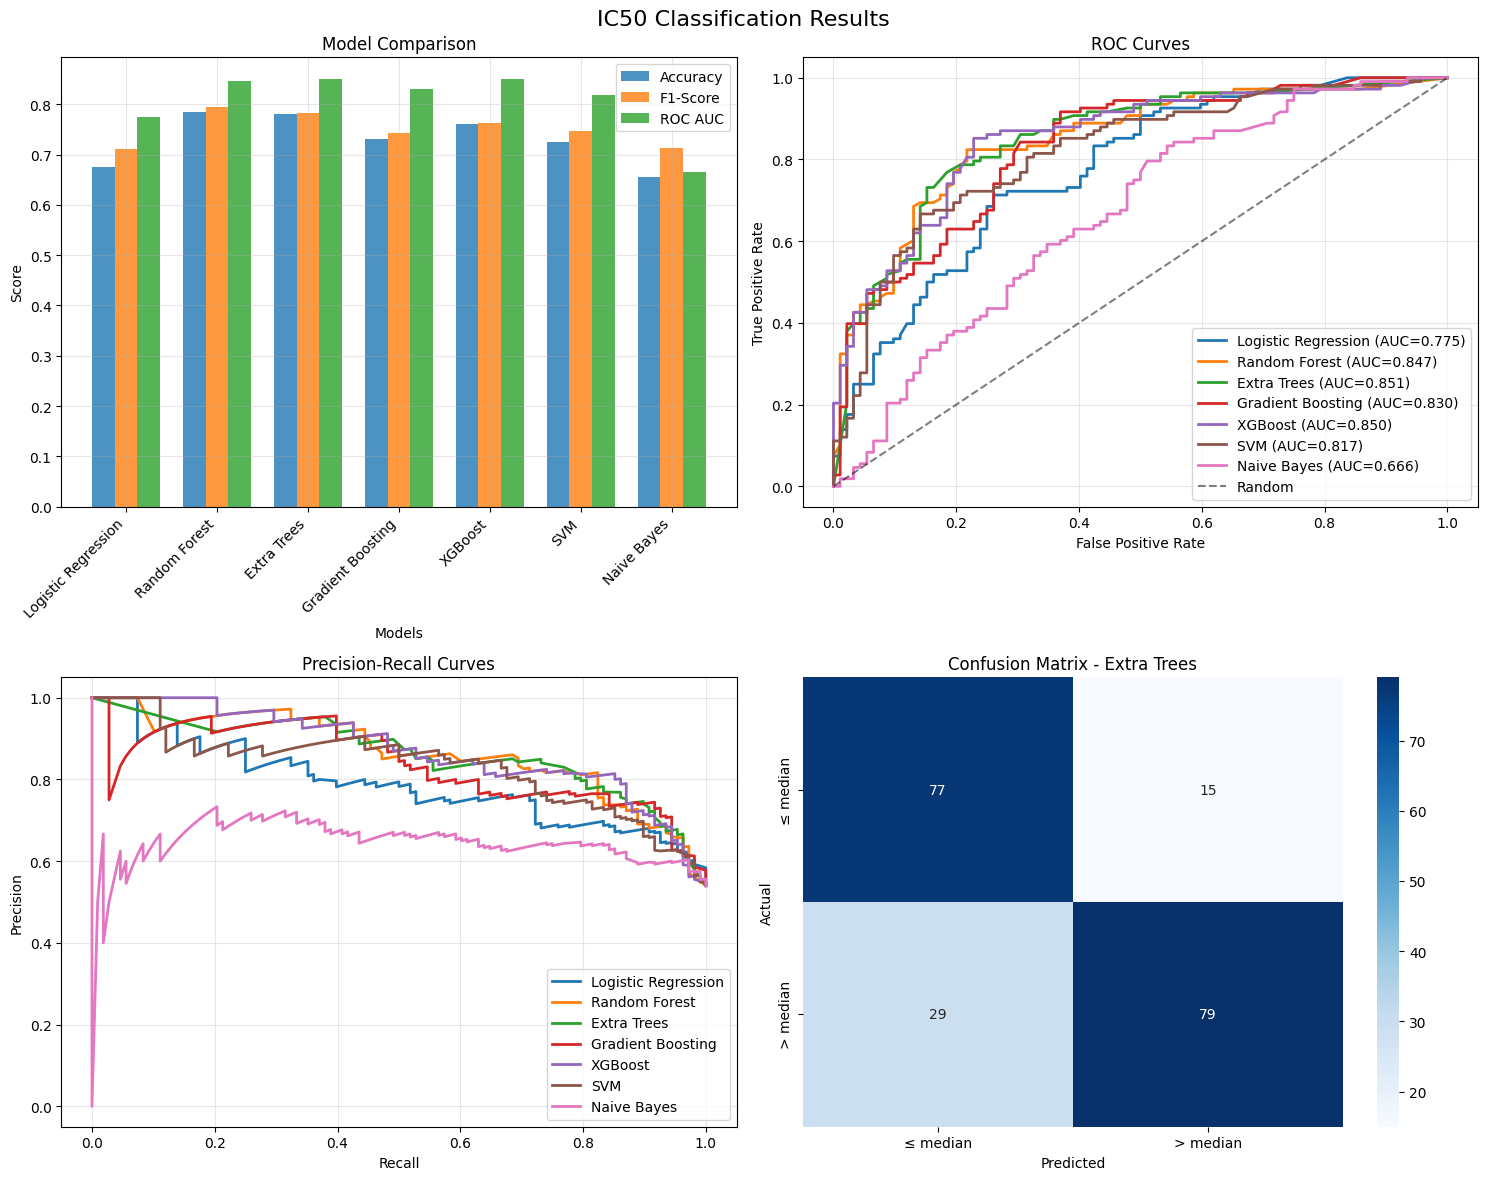

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('IC50 Classification Results', fontsize=16)

# 1. Сравнение моделей
ax1 = axes[0, 0]
x_pos = np.arange(len(results_df))
width = 0.25

ax1.bar(x_pos - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax1.bar(x_pos, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width, results_df['ROC AUC'], width, label='ROC AUC', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC кривые
ax2 = axes[0, 1]
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    auc_score = results[name]['roc_auc']
    ax2.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall кривые
ax3 = axes[1, 0]
for name in results.keys():
    precision, recall, _ = precision_recall_curve(y_test, results[name]['y_pred_proba'])
    ax3.plot(recall, precision, label=name, linewidth=2)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix лучшей модели
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, best_model['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['≤ median', '> median'],
            yticklabels=['≤ median', '> median'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

#МОДЕЛЬ: Extra Trees

77 - True Negatives (правильно предсказан класс "≤ median")

15 - False Positives (ошибочно предсказан как "> median")

29 - False Negatives (ошибочно предсказан как "≤ median")

79 - True Positives (правильно предсказан класс "> median")

Accuracy = (77 + 79) / (77 + 15 + 29 + 79) = 156/200 = 78%

Класс "≤ median": 77/(77+29) = 72.6% - хорошо

Класс "> median": 79/(15+79) = 84.0% - отлично

Полнота (Recall):

Класс "≤ median": 77/(77+15) = 83.7%

Класс "> median": 79/(29+79) = 73.1%

Модель неплохо разделила классы (78% точность), правильных предсказаний больше, чем ошибок.
Но модель допустила 15 ложных срабатываний - соединения с IC50 ≤ медианы модель считает активными, и 29 пропусков - активные соединения (> медианы) модель считает неактивными.

Т.е. мы ложно отбираем 15 соединений  и упускаем 29 потенциально активных


In [16]:
comparison_data = []
true_0, true_1 = sum(y_test == 0), sum(y_test == 1)

for name in results.keys():
    y_pred = results[name]['y_pred']
    pred_0, pred_1 = sum(y_pred == 0), sum(y_pred == 1)
    correct = sum(y_test == y_pred)

    comparison_data.append({
        'Model': name,
        'True_Class_0 (≤ медианы)': true_0,
        'True_Class_1 (> медианы)': true_1,
        'Pred_Class_0 (≤ медианы)': pred_0,
        'Pred_Class_1 (> медианы)': pred_1,
        'Correct': correct,
        'Total': len(y_test),
        'Accuracy': correct/len(y_test)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nСводная таблица предсказаний:")
print(comparison_df.to_string(index=False))


Сводная таблица предсказаний:
              Model  True_Class_0 (≤ медианы)  True_Class_1 (> медианы)  Pred_Class_0 (≤ медианы)  Pred_Class_1 (> медианы)  Correct  Total  Accuracy
Logistic Regression                        92                       108                        83                       117      135    200     0.675
      Random Forest                        92                       108                        99                       101      157    200     0.785
        Extra Trees                        92                       108                       106                        94      156    200     0.780
  Gradient Boosting                        92                       108                        98                       102      146    200     0.730
            XGBoost                        92                       108                       106                        94      152    200     0.760
                SVM                        92                       1